In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# LOADING DATA - Fashion MNIST
# DataSet class for PyTorch and tf.data for TensorFlow.

# Pytorch

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
# create the transformer for put the data to the tensor
transform = transforms.Compose([transforms.ToTensor()])

# load the train data - if not exists download it
train_dataset_py = torchvision.datasets.FashionMNIST(root='./sample_data',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset_py = torchvision.datasets.FashionMNIST(root='./sample_data',
                                             train=False, 
                                             transform=transform,
                                             download=True)

In [4]:
def imshowPytorch(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

(32, 1, 28, 28)
tensor(9)


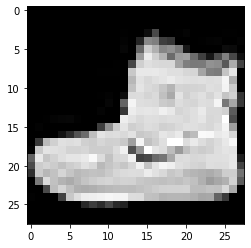

In [5]:
# create a data loader - I will use it for the training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_py,
                                           batch_size=32,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_py,
                                           batch_size=32,
                                           shuffle=False)
                                           
data_iter = iter(train_loader)

images, labels = next(data_iter)
print(images.numpy().shape)
imshowPytorch(torchvision.utils.make_grid(images[0]))
print(labels[0])

In [113]:
# For PyTorch, we also have two modes of the model: train and production. 
# To put the model in the production mode, we just have to use method .eval() 
# Once the model is in the production mode, some methods will be turned off automatically, such as dropout.
# To move it to the training mode, we have to use method .train() as train is the default mode.

class NeuralNet(nn.Module):
    def __init__(self, num_of_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        #     nn.MaxPool2d(kernel_size=2, stride=2))
        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        #     # nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2))
        # self.fc = nn.Linear(7 * 7 * 32, num_of_class)
        
        self.fc = nn.Linear(9216, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        #         # out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [114]:
model_py = NeuralNet(10)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_py.parameters())

model_py

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=9216, out_features=10, bias=True)
)

In [115]:
%%time
for e in range(1):
    # define the loss value after the epoch
    losss = 0.0
    number_of_sub_epoch = 0
    
    # loop for every training batch (one epoch)
    for images, labels in train_loader:
        #create the output from the network
        out = model_py(images)
        # count the loss function
        loss = criterion(out, labels)
        # in pytorch you have assign the zero for gradient in any sub epoch
        optim.zero_grad()
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        # add new value to the main loss
        losss += loss.item()
        number_of_sub_epoch += 1
    print("step {}: loss: {}".format(e, losss / number_of_sub_epoch))

step 0: loss: 0.44893012918829917
CPU times: user 49.5 s, sys: 484 ms, total: 50 s
Wall time: 28.6 s


In [116]:
correct = 0
total = 0
model_py.eval()
for images, labels in test_loader:
    outputs = model_py(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct / total))

Test Accuracy of the model on the 10000 test images: 87.48999786376953%


In [117]:
# save the models.
torch.save(model_py, "model_py.pt")

---
**Loading the saved pytorch model**
___

In [118]:
# load the model:
model_load_py = torch.load("model_py.pt")
model_load_py

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=9216, out_features=10, bias=True)
)

In [119]:
# keras like summary

from torchsummary import summary
summary(model_load_py, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
       BatchNorm2d-3           [-1, 16, 24, 24]              32
            Linear-4                   [-1, 10]          92,170
Total params: 92,618
Trainable params: 92,618
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.35
Estimated Total Size (MB): 0.57
----------------------------------------------------------------


In [120]:
# check if the model was saved with the weight 
correct = 0
total = 0
for images, labels in test_loader:
    outputs = model_load_py(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct / total))

Test Accuracy of the model on the 10000 test images: 87.48999786376953%


In [121]:
# load weights from pytorch model

# #CONV2D
conv2d = model_load_py.layer1[0].state_dict()
weights0 = conv2d['weight'].numpy()
print(weights0.shape, weights0[0, 0, 0, :5])
bias0 = conv2d['bias'].numpy()
print(bias0.shape, bias0[:5])

# BATCH NORM
batch_norm = model_load_py.layer1[2].state_dict()
weight0 = batch_norm['weight'].numpy()
bias0 = batch_norm['bias'].numpy()
rmean = batch_norm['running_mean'].numpy()
rvar = batch_norm['running_var'].numpy()
print(weight0.shape, weight0[:5])
print(bias0.shape, bias0[:5])
print(rmean.shape, rmean[:5])
print(rvar.shape, rvar[:5])

# LINEAR
fc = model_load_py.fc.state_dict()
weights = fc['weight'].numpy()
print(weights.shape, weights[0, :5])
bias = fc['bias'].numpy()
print(bias.shape, bias[:5])

(16, 1, 5, 5) [ 0.1565587   0.12268871  0.12622112 -0.22293016  0.1205987 ]
(16,) [ 0.02704382 -0.14164135 -0.227082    0.03655862 -0.09029163]
(16,) [0.35765034 0.85456157 0.73478514 0.50098115 0.5532688 ]
(16,) [-0.02144467  0.00027201  0.01555244  0.08424513  0.05354267]
(16,) [1.9148977e-01 9.8308428e-06 7.1580798e-05 1.2939961e-02 1.3746850e-02]
(16,) [2.5555780e-02 4.3356511e-07 6.1809624e-06 8.0470799e-04 1.7845844e-03]
(10, 9216) [-0.02324438 -0.00191114 -0.00253256 -0.0063062  -0.01364839]
(10,) [ 0.02073159  0.00741996 -0.00192046  0.00374859 -0.02121427]


# Tensorflow

In [122]:
import tensorflow as tf
from tensorflow import keras 

In [123]:
# Load the data set
fashion_mnist = keras.datasets.fashion_mnist
#split to test and train
(train_images_tf, train_labels_tf), (test_images_tf, test_labels_tf) = fashion_mnist.load_data()

train_images_tf = train_images_tf / 255.0
test_images_tf = test_images_tf / 255.0

In [124]:
print("Train Shape before", train_images_tf.shape)
print("Test Shape before", test_images_tf.shape)

Train Shape before (60000, 28, 28)
Test Shape before (10000, 28, 28)


In [125]:
train_images_tf = train_images_tf[:, :, :, np.newaxis]
print("Train Shape after", train_images_tf.shape)
test_images_tf = test_images_tf[:, :, :, np.newaxis]
print("Test Shape after", test_images_tf.shape)

Train Shape after (60000, 28, 28, 1)
Test Shape after (10000, 28, 28, 1)


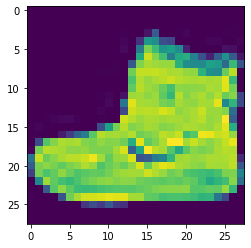

In [126]:
plt.imshow(train_images_tf[0].reshape(28, 28))

In [147]:
model_tf = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1), batch_size=32),
    keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="relu"),
    keras.layers.BatchNormalization(), 
    # keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation=tf.nn.relu),
    # keras.layers.BatchNormalization(), 
    # keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Permute((3, 1, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

In [148]:
model_tf.compile(optimizer=keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_tf.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (32, 24, 24, 16)          416       
_________________________________________________________________
batch_normalization_7 (Batch (32, 24, 24, 16)          64        
_________________________________________________________________
permute_5 (Permute)          (32, 16, 24, 24)          0         
_________________________________________________________________
flatten_7 (Flatten)          (32, 9216)                0         
_________________________________________________________________
dense_7 (Dense)              (32, 10)                  92170     
Total params: 92,650
Trainable params: 92,618
Non-trainable params: 32
_________________________________________________________________


In [149]:
# get the current weights of tensorflow model

# # CONV2D
w0, b0 = model_tf.layers[0].get_weights()
print(w0.shape, w0[0, 0, 0, :5])
print(b0.shape, b0[:5])

# BATCH NORM
w1, b1, mu, var = model_tf.layers[1].get_weights()
print(w1.shape, w1[:5])
print(b1.shape, b1[:5])
print(mu.shape, mu[:5])
print(var.shape, var[:5])

# lINEAR
w, b = model_tf.layers[4].get_weights()
print(w.shape, w[0,:5])
print(b.shape, b[:5])

(5, 5, 1, 16) [ 0.00230907 -0.05596308  0.06874196  0.08860019 -0.11029251]
(16,) [0. 0. 0. 0. 0.]
(16,) [1. 1. 1. 1. 1.]
(16,) [0. 0. 0. 0. 0.]
(16,) [0. 0. 0. 0. 0.]
(16,) [1. 1. 1. 1. 1.]
(9216, 10) [-0.01712917  0.02042163 -0.02043371  0.02418322 -0.00282468]
(10,) [0. 0. 0. 0. 0.]


In [150]:
predictions = model_tf.predict(test_images_tf)
correct = 0
for i, pred in enumerate(predictions):
    if np.argmax(pred) == test_labels_tf[i]:
        correct += 1
print('Test Accuracy of the model on the {} test images: {}%'.format(test_images_tf.shape[0],
                                                                     100 * correct/test_images_tf.shape[0]))

Test Accuracy of the model on the 10000 test images: 10.71%


In [151]:
loss, acc = model_tf.evaluate(test_images_tf, test_labels_tf)
print(f"accuracy {acc * 100}%")

313/313 [==============================] - 2s 8ms/step - loss: 2.3198 - accuracy: 0.1069
accuracy 10.692891478538513%


In [152]:
# pass loaded weights to tensorflow model

# #CONV2D
model_tf.layers[0].set_weights([weights0.transpose(2, 3, 1, 0), bias0.T])
w0, b0 = model_tf.layers[0].get_weights()
print(w0.shape, w0[0, 0, 0, :5])
print(b0.shape, b0[:5])

#BATCH NORM
model_tf.layers[1].set_weights([weight0.T, bias0.T, rmean.T, rvar.T])
w1, b1, mu, var = model_tf.layers[1].get_weights()
print(w1.shape, w1[:5])
print(b1.shape, b1[:5])
print(mu.shape, mu[:5])
print(var.shape, var[:5])

#DENSE
model_tf.layers[4].set_weights([weights.T, bias.T])
w, b = model_tf.layers[4].get_weights()
print(w.shape, w[0,:5])
print(b.shape, b[:5])

(5, 5, 1, 16) [ 0.1565587  -0.14232314  0.03972157  0.12053496  0.01569638]
(16,) [-0.02144467  0.00027201  0.01555244  0.08424513  0.05354267]
(16,) [0.35765034 0.85456157 0.73478514 0.50098115 0.5532688 ]
(16,) [-0.02144467  0.00027201  0.01555244  0.08424513  0.05354267]
(16,) [1.9148977e-01 9.8308428e-06 7.1580798e-05 1.2939961e-02 1.3746850e-02]
(16,) [2.5555780e-02 4.3356511e-07 6.1809624e-06 8.0470799e-04 1.7845844e-03]
(9216, 10) [-0.02324438  0.00205207  0.00207317  0.01123369  0.00536022]
(10,) [ 0.02073159  0.00741996 -0.00192046  0.00374859 -0.02121427]


In [153]:
predictions = model_tf.predict(test_images_tf)
correct = 0
for i, pred in enumerate(predictions):
    if np.argmax(pred) == test_labels_tf[i]:
        correct += 1
print('Test Accuracy of the model on the {} test images: {}%'.format(test_images_tf.shape[0],
                                                                     100 * correct/test_images_tf.shape[0]))

Test Accuracy of the model on the 10000 test images: 61.34%


In [154]:
loss, acc = model_tf.evaluate(test_images_tf, test_labels_tf)
print(f"accuracy {acc * 100}%")

313/313 [==============================] - 2s 7ms/step - loss: 1.5989 - accuracy: 0.6124
accuracy 61.24201416969299%


In [ ]:
# save the model 
model_tf.save('model_tf.h5')

In [ ]:
# load the model
model_load_tf = tf.keras.models.load_model('model_tf.h5')
model_load_tf.summary()
test_loss, test_acc = model_load_tf.evaluate(test_images_tf, test_labels_tf)
print('Test accuracy:', test_acc * 100)

---


In [ ]:
# weights and bias of layers from pytorch loaded model
py_weights_1 = np.array(model_load_py.layer1[0].weight.data).T
py_bias_1 = np.array(model_load_py.layer1[0].bias.data).T

# py_weights_2 = np.array(model_load_py.layer1[1].weight.data).T
# py_bias_2 = np.array(model_load_py.layer1[1].bias.data).T

py_weights_5 = np.array(model_load_py.layer2[0].weight.data).T
py_bias_5 = np.array(model_load_py.layer2[0].bias.data).T

# py_weights_6 = np.array(model_load_py.layer2[1].weight.data)
# py_bias_6 = np.array(model_load_py.layer2[1].bias.data)

py_weights_9 = np.array(model_load_py.fc.weight.data).T
py_bias_9 = np.array(model_load_py.fc.bias.data).T

In [ ]:
modeltf.layers[0].set_weights([py_weights_1, py_bias_1])
# modeltf.layers[1].set_weights([py_weights_2, py_bias_2, np.zeros(py_weights_2.shape), np.ones(py_weights_2.shape)])
modeltf.layers[2].set_weights([py_weights_5, py_bias_5])
# modeltf.layers[4].set_weights([py_weights_6, py_bias_6, np.zeros(py_weights_6.shape), np.ones(py_weights_6.shape)])
modeltf.layers[5].set_weights([py_weights_9, py_bias_9])

# modeltf.layers[0].get_weights()
# modeltf.layers[0].set_weights([w, b])
# weights, bias = modeltf.layers[0].get_weights()
# weights_tf1, bias_tf1, _, _= np.array(modeltf.layers[1].get_weights())
# weights_tf1 = weights_py1
# print(weights_tf1)
# modeltf.layers[1].get_weights()[0]
# print(w.shape)
# print(b.shape)

### DO NOT TRAIN

In [ ]:
predictions = model_tf.predict(test_images_tf)
correct = 0
for i, pred in enumerate(predictions):
  if np.argmax(pred) == test_labels_tf[i]:
    correct += 1
print('Test Accuracy of the model on the {} test images: {}%'.format(test_images_tf.shape[0],
                                                                     100 * correct/test_images_tf.shape[0]))


In [ ]:
%%time
# Because Fashion MNIST in TensorFlow is an array with only two dimensions, 
# we have to add the number of channels (in our case it’s just one):

train_images_tf = train_images_tf.reshape(1, train_images_tf.shape[0], 
                                          train_images_tf.shape[1],
                                          train_images_tf.shape[2])

modeltf.fit(train_images_tf, train_labels_tf, epochs=10)

In [ ]:
# another way of inference
test_loss, test_acc = modeltf.evaluate(test_images_tf, test_labels_tf)
print('Test accuracy:', test_acc)

## CONTINUE FROM HERE

In [ ]:
# save the model 
modeltf.save('modeltf.h5')

In [ ]:
# load the model
model_load_tf = tf.keras.models.load_model('modeltf.h5')
model_load_tf.summary()
test_loss, test_acc = model_load_tf.evaluate(test_images_tf, test_labels_tf)
print('Test accuracy:', test_acc)

# In summary
<hr>

**Tensorflow**
>Pros:
* Simple built-in high level API
* Tensorboard (easy to use visualisation tool)
* Simple serving method on production
* Very good documentation
* Easy mobile support

>Cons:
* Static graph
* Debugging method
* Hard to make quick changes
<hr>

**Pytorch**
>Pros:
* Python-like coding
* Dynamic graph
* Easy & quick editing
* Very good documentation available
* Plenty of projects out there which use Pytorch

>Cons:
* Third party needed for visualisation
* API knowledge needed in Python to move to production
<hr>

<pre>
You can check shapes of all weights of all keras layers quite simply:

for layer in model.layers:
    print([tensor.shape for tensor in layer.get_weights()])
This would give you shapes of all weights (including biases), so you can prepare loaded numpy weights accordingly.

To set them, do something similar:

for torch_weight, layer in zip(model.layers, torch_weights):
    layer.set_weights(torch_weight)
where torch_weights should be a list containing lists of np.array which you would have to load.

Usually each element of torch_weights would contain one np.array for weights and one for bias.

Remember shapes received from print have to be exactly the same as the ones you put in set_weights.
</pre>